In [1]:
pip install sentence-transformers umap-learn hdbscan bertopic wordcloud

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import re
import warnings
from collections import namedtuple
from types import NoneType

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import ParameterSampler, ParameterGrid
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.manifold import TSNE

from tqdm import tqdm

from sentence_transformers import SentenceTransformer
import umap
import hdbscan

from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance, KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

from wordcloud import WordCloud

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Some custom functions we'll use

In [4]:
def cluster_and_score_pipeline(pipeline, X, y=None):
    scores_dict = {}

    # Fit the pipeline
    pipeline.fit(X)

    # Extract clusters from the fitted model
    cluster_labels = pipeline.named_steps['clusterer'].labels_

    # Transform the data to get the reduced representation
    dim_reduced_embeddings = pipeline.named_steps['reduction'].transform(X)

    # Score calculations that require y
    if not isinstance(y, NoneType):
        # if we happen to have class labels for the dataset,
        # we'll leverage this “supervised” ground truth information to quantify the quality of the resulting clusters
        scores_dict["Homogeneity"] = metrics.homogeneity_score(y, cluster_labels)
        scores_dict["Completeness"] = metrics.completeness_score(y, cluster_labels)
        scores_dict["V-measure"] = metrics.v_measure_score(y, cluster_labels)
        scores_dict["Adjusted Rand-Index"] = metrics.adjusted_rand_score(y, cluster_labels)

    # Score calculations that don't require y
    scores_dict["Silhouette Coefficient"] = metrics.silhouette_score(dim_reduced_embeddings, cluster_labels)

    return scores_dict

def evaluate_params(estimator, X, y=None, params=None):
    # Create a clone of the estimator to avoid modifying the original
    temp_estimator = clone(estimator)
    temp_estimator.set_params(**params)

    current_score = cluster_and_score_pipeline(temp_estimator, X, y)
    return current_score

def custom_grid_search(estimator, X, y=None, param_grid=None, random_search=False, n_iter=20, random_state=None):
    all_param_grid = ParameterSampler(param_grid, n_iter,
                            random_state=random_state
                    ) if random_search else ParameterGrid(param_grid)

    R = namedtuple("Result", ["best_score_", "best_params_", "best_estimator_"])
    best_result = R(best_score_={"Silhouette Coefficient": -np.inf},
                    best_params_=None, best_estimator_=None)
    scores = []
    params_list = []

    for params in tqdm(all_param_grid, desc="Running", colour="blue"):
        score = evaluate_params(estimator, X, y, params=params)
        score_mean = np.mean(list(score.values()))

        # Update best result if the current score is better
        best_score = best_result.best_score_
        best_score_mean = np.mean(list(best_score.values()))
        if score_mean > best_score_mean:
            best_result = R(score, params, estimator.set_params(**params))

        scores.append(score)
        params_list.append(params)

    return best_result, pd.DataFrame(scores), params_list

In [5]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


In [6]:
def visualize_clusters(X, y, plot_dimensions=2):
    assert plot_dimensions == 2 or plot_dimensions == 3, "plot_dimensions must be 2(for 2-D plots) or 3(for 3-D plots)"

    # Reduce dimensionality using tsne for visualization purposes
    tsne = TSNE(n_components=plot_dimensions)
    dim_reduced_embeddings = tsne.fit_transform(X)

    if plot_dimensions == 2:
        plt.scatter(dim_reduced_embeddings[:, 0], dim_reduced_embeddings[:, 1],
                    c=y, s=10, cmap="tab10")
        plt.title("2D visualization of clusters")

    elif plot_dimensions == 3:
        fig = plt.figure(figsize = (10, 7))
        ax = plt.axes(projection ="3d")
        ax.scatter3D(dim_reduced_embeddings[:,0], dim_reduced_embeddings[:,1],
                     dim_reduced_embeddings[:,2], c=y)
        plt.title("3D visualization of clusters")

    plt.show()

In [7]:
random_state = 42

### 1. Get Data

In [8]:
categories = ["alt.atheism", "talk.religion.misc", "comp.graphics",
              "sci.space",]
dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="train",
    # categories=categories,
    shuffle=True,
    random_state=random_state
)


In [9]:
X = dataset.data
y = dataset.target
unique_labels, category_sizes = np.unique(y, return_counts=True)
total_categories = unique_labels.shape[0]

In [10]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [11]:
['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### 2. Embeddings

In [12]:
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
# By default, this model truncates input text longer than 256 word pieces.
# Our dataset has input texts with more than 256 word pieces. However, since this
# is just for practice purposes, let's ignore this fact.

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
# use gpu for a faster embedding process
embeddings = embedding_model.encode(X, show_progress_bar=True) # for the unsplit dataset

Batches:   0%|          | 0/354 [00:00<?, ?it/s]

### 3. Dimensionality Reduction

In [14]:
# Make pipeline
pipeline = Pipeline([
    ("reduction", umap.UMAP(metric='cosine', random_state=random_state)), # Apply dimensionality reduction
    ("clusterer", hdbscan.HDBSCAN()) # Cluster

])

In [15]:
param_grid =  {
    'reduction__n_neighbors': [25, 35, 45],
    'reduction__n_components': [2, 3, 4],
    'clusterer__min_samples': [None, 20,],
    'clusterer__min_cluster_size': [75, 100, 125],
}
randomize_search = False
n_iter = 20 # Number of parameter sets to try(if randomized search)

In [16]:
n_iter = 100 # Number of parameter sets to try(if randomized search)
param_grid =  {
    'reduction__n_components': [2, 3, 4, 5, 10, 25, 50],
    'reduction__n_neighbors': [15, 25, 35, 50],
    'clusterer__min_cluster_size': [5, 15, 25, 50, 75, 100, 125],
    'clusterer__min_samples': [None, 5, 10, 15, 25, 40, 50]
}
randomize_search = True

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning) # suppress umap's `n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.` warning

    # To:Do => make this process faster(perhaps concurrent.futures.ProcessPoolExecutor implementation)
    result, scores, params = custom_grid_search(pipeline, embeddings, y,
                            param_grid=param_grid, random_search=randomize_search,
                            n_iter=n_iter, random_state=random_state)


Running:  93%|█████████▎| 93/100 [36:12<02:41, 23.09s/it]

In [35]:
result.best_params_

{'reduction__n_neighbors': 50,
 'reduction__n_components': 2,
 'clusterer__min_samples': 50,
 'clusterer__min_cluster_size': 15}

In [36]:
result.best_score_

{'Homogeneity': 0.4372948018091495,
 'Completeness': 0.5806325252347484,
 'V-measure': 0.49887173337576685,
 'Adjusted Rand-Index': 0.2168849848475326,
 'Silhouette Coefficient': 0.3130398}

In [37]:
pipeline = result.best_estimator_
pipeline.named_steps["clusterer"].set_params(prediction_data=True) # For faster predictions later on

HDBSCAN(min_cluster_size=15, min_samples=50, prediction_data=True)

In [38]:
# fit pipeline
pipeline.fit(embeddings)
# Get dimensionality reduced embeddings
dim_reduced_embeddings = pipeline.named_steps['reduction'].transform(embeddings)
labels = pipeline.named_steps["clusterer"].labels_

In [39]:
cluster_ids, cluster_sizes = np.unique(labels, return_counts=True)
print(f"Clusters: {cluster_ids}\nNumber of elements assigned to each cluster: {cluster_sizes}\n\n")
print(f"\nTrue Clusters: {unique_labels}\nTrue number of documents in each category according to the true class labels: {category_sizes}")

Clusters: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of elements assigned to each cluster: [2202  319 1069  528  150  345  998 3436   25   99  338  326  132  274
  139   72  718   28  116]



True Clusters: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
True number of documents in each category according to the true class labels: [480 584 591 590 578 593 585 594 598 597 600 595 591 594 593 599 546 564
 465 377]


### Visualization

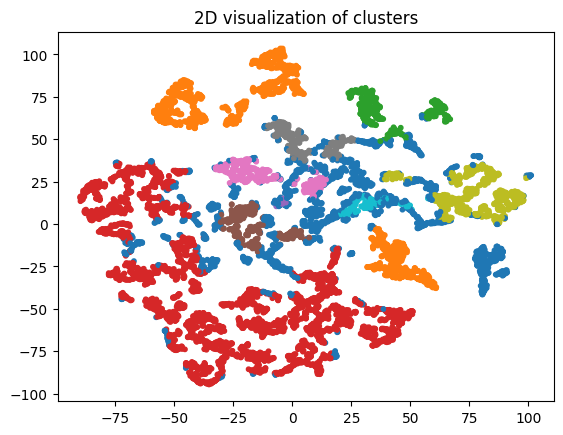

In [40]:
# visualize cluster in 2-D
visualize_clusters(dim_reduced_embeddings, labels, plot_dimensions=2)

In [41]:
if dim_reduced_embeddings.shape[-1] > 2:
    # visualize cluster in 3-D
    visualize_clusters(dim_reduced_embeddings, labels, plot_dimensions=3)

## Topic Modeling Section

In [42]:
representation_model = KeyBERTInspired()
vectorizer_model = CountVectorizer(stop_words="english")

# models from our document clustering section
reduction_model = pipeline.named_steps["reduction"]
cluster_model = pipeline.named_steps["clusterer"]

In [43]:
topic_model = BERTopic(
    representation_model=representation_model,
    vectorizer_model=vectorizer_model,

    umap_model=reduction_model,
    hdbscan_model=cluster_model,
    embedding_model=embedding_model,
)

In [44]:
topics, probs = topic_model.fit_transform(X, embeddings)

In [45]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2202,-1_output_chz_ax_b8f,"[output, chz, ax, b8f, bhj, 7ey, max, ve, m3, ll]",[\n------------ Part 5 of 14 ------------\nM)B...
1,0,3436,0_hardware_ram_ibm_scsi,"[hardware, ram, ibm, scsi, drives, disk, os, p...","[Hello, I have a motherboard and a case for sa..."
2,1,1069,1_puck_nhl_scoring_flyers,"[puck, nhl, scoring, flyers, leafs, hockey, ra...",[Philadelphia 1 2 4--7\nBu...
3,2,998,2_vehicle_honda_driving_ford,"[vehicle, honda, driving, ford, motorcycle, ca...",[Sixteen days I had put off test driving the H...
4,3,718,3_scripture_atheism_christians_christianity,"[scripture, atheism, christians, christianity,...",[: I will clarify my earlier quote. God's law...
5,4,528,4_medicine_patients_clinical_doctors,"[medicine, patients, clinical, doctors, treatm...","[\n\nIf people are going to do this, I really ..."
6,5,345,5_palestinians_gaza_gazans_israeli,"[palestinians, gaza, gazans, israeli, israelis...","[\nThis a ""tried and true"" method utilized by ..."
7,6,338,6_saturn_nasa_spacecraft_orbiter,"[saturn, nasa, spacecraft, orbiter, astronomy,...",[Archive-name: space/probe\nLast-modified: $Da...
8,7,326,7_clipper_encryption_decrypt_cryptography,"[clipper, encryption, decrypt, cryptography, c...",[I saw this article posted in a local newsgrou...
9,8,319,8_hello_hi__,"[hello, hi, , , , , , , , ]","[Hello,, \n\tWhatta ass!!!!!\n\n, Hello,]"


### View Wordcloud

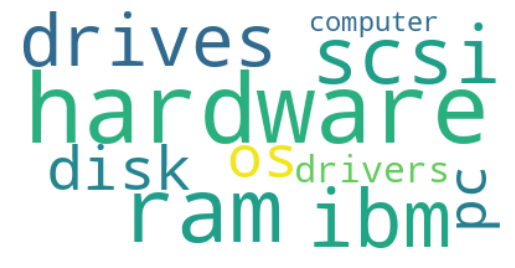

In [64]:
topic_number = 0
create_wordcloud(topic_model, topic=topic_number)

### Predicting Topics for new instances

In [65]:
categories = ["comp.graphics"]
test_dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="test",
    categories=categories,
    shuffle=True,
    random_state=42
)


In [66]:
X_test = test_dataset.data

test_embeddings = embedding_model.encode(X_test, show_progress_bar=True)

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [67]:
topics, probs = topic_model.transform(X_test, test_embeddings)

In [ ]:
topic_labels, sizes = np.unique(topics, return_counts=True)
most_common_label = topic_labels[np.argmax(sizes)]

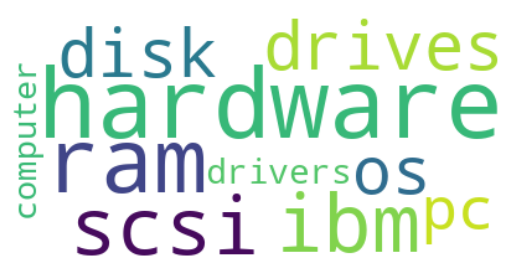

In [68]:
create_wordcloud(topic_model, topic=most_common_label)

We see that the most common label happens to be on computer graphics which is what our data is